## Lab 2: Malware analysis using VirusTotal reports on malware samples

### Objectives of the lab:
   - See where to extract MD5 hashes from and use them to access VirusTotal API – obtain reports on the malware samples.
   - Learn about various attributes of malwares that would be used to characterize the samples based on their families or types
   - Learn how to convert various attributes of the malwares into feature vectors suitable for data mining


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/Volumes/GoogleDrive/My Drive/Spring 19/CSE 494 Labs/Lab 2/lab2_md5_types.csv')

In [3]:
df.head()

,Tojan,Virus,Backdoor,Worm
0,60281d0a5891a6e5102cbde0fea0b20f,64d15027a172ca2dfbd4057c44ae8615,a11e71cc8cf90ab7b5b31fc7cbf4c619,d392ac090591df46727a9fa8b8988e14
1,d9abaa24d63788ee7b3bfece630ca452,4fa26d84d8bbcb38537fefc1100cc28f,fec1ca19c3762df43b6c3084d05cc591,c9cb8479ede835942b36eb4df49207bb
2,bea8977502efd36441e9e004f6b3e720,2562a401c7502fabc9f0cb05c98af5c5,69ca370e29f51faa437f1cf657115517,1a2e10c555f6340259727100e5addd2c
3,57157cc6d0e21f2be2cf93caaac5f5c8,ffda0fe069a1cee6fdc0ff87c401d93d,7f8ed44b771e7ba6716f5dd44ea7161e,a7f8130bad3e97ea3758b269b26c48c4
4,2dec428d9a1fc1a2eda1a0e533f6f61f,a6f193dd1ef265c5b23e55511bf18f9d,e55d4e0d5273d2b31651b1c47ae80ce6,fa67d179d5cea659d47150147ec83385


#### The columns represent the malware families and each cell is a md5 hash

In [4]:
df = df.iloc[:,1:]
df.head()

,Virus,Backdoor,Worm
0,64d15027a172ca2dfbd4057c44ae8615,a11e71cc8cf90ab7b5b31fc7cbf4c619,d392ac090591df46727a9fa8b8988e14
1,4fa26d84d8bbcb38537fefc1100cc28f,fec1ca19c3762df43b6c3084d05cc591,c9cb8479ede835942b36eb4df49207bb
2,2562a401c7502fabc9f0cb05c98af5c5,69ca370e29f51faa437f1cf657115517,1a2e10c555f6340259727100e5addd2c
3,ffda0fe069a1cee6fdc0ff87c401d93d,7f8ed44b771e7ba6716f5dd44ea7161e,a7f8130bad3e97ea3758b269b26c48c4
4,a6f193dd1ef265c5b23e55511bf18f9d,e55d4e0d5273d2b31651b1c47ae80ce6,fa67d179d5cea659d47150147ec83385


#### Iterate over the columns and retrieve the VirusTotal Reports for each md5

In [5]:
def load_requests(md5, family):
    '''
    Input: md5 hash
    Output: dictionary with the metadata key-value pairs
    
    '''
    metadata = {}
    metadata['md5'] = md5
    metadata['family'] = family
    
    params = {'apikey': 'f2f9bb5419691e82420cc5cba8ec39285eeec5a3a1bed5a459d79f66cc542b62',
              'resource': md5, 'allinfo': 1}
    headers = {
        "Accept-Encoding": "gzip, deflate",
        "User-Agent": "gzip,  My Python requests library example client or username"
    }
    response = requests.get('https://www.virustotal.com/vtapi/v2/file/report',
                            params=params, headers=headers)
    json_response = response.json()
    
    # if no metadata present, just skip the md5
    if 'additional_info' not in json_response:
        return {} 
    
    for f in json_response['additional_info']['exiftool']:
        metadata[f] = json_response['additional_info']['exiftool'][f]
    
    return metadata

### Missing Value Imputation

There are a multitude of ways to impute missing values - refer http://www.stat.columbia.edu/~gelman/arm/missing.pdf for moreinformation - for example, building predictors for missing values

 scikit learn's SimpleImputerMethod is quite useful https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer

$$
\textbf{SimpleImputer}(missing\_values=nan, strategy= 'mean', fill\_value=None, verbose=0, copy=True)
$$


### NOTE: From 0.20 onwards the Scikit learn uses this SimpleImputer Method, for versions before the equivalent method is Imputer().

For this lab,we will use a generic imputer class that handles both numeric and non-numeric attributes 

In [59]:
columns_to_select = []

for column in df_metadata.columns:
    num_missing = (df_metadata[column]).isnull().sum()
#     print(column, num_missing)

    if num_missing < 10:
        columns_to_select.append(column)

df_metadata = df_metadata[columns_to_select]
df_metadata.to_csv('../../data/lab2/lab2_md5_feat_filtered.csv')

# manually curate features
columns_feat = ['md5', 'EntryPoint', 'family', 'LinkerVersion', 'CodeSize', 'InitializedDataSize']
df_metadata = df_metadata[columns_feat]
        
df_metadata.to_csv('../../data/lab2/lab2_md5_feat_v1.csv')

    

In [71]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [113]:
# Impute missing values grouped by each family
from sklearn.preprocessing import Imputer

feat_data_types = ['EntryPoint', 'LinkerVersion', 'CodeSize', 'InitializedDataSize']


families = list(set(df_metadata['family']))

df_imputed = pd.DataFrame(columns=df_metadata.columns)
for f in families:
    df_family = df_metadata[df_metadata['family'] == f]
    
    df_family = DataFrameImputer().fit_transform(df_family)
    
    df_imputed = df_imputed.append(df_family)
    
# df_imputed.to_csv('../../data/lab2/lab2_md5_feat_imputed.csv')
    

### Malware Analysis of features by family type - comparison by family types

In [135]:
# Analyze the numerical features family wise

df_imputed['CodeSize'] = pd.to_numeric(df_imputed['CodeSize'])
df_plot = df_imputed.groupby(['family'])['CodeSize'].mean()

df_plot.describe

# df_plot.plot.bar()

<bound method NDFrame.describe of family
Teslacrypt    73703.619048
dridex        38204.952381
locky         67043.555556
xtreme        45836.190476
Name: CodeSize, dtype: float64>

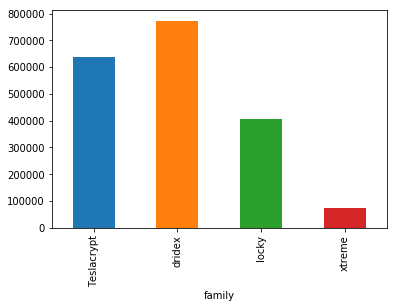

In [120]:
df_imputed['InitializedDataSize'] = pd.to_numeric(df_imputed['InitializedDataSize'])
df_plot = df_imputed.groupby(['family'])['InitializedDataSize'].mean()

df_plot.plot.bar()

### Feature vectorization - for different type of features


- #### For extracting n-grams or text features, you can look into scikit-learn's methods: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


In [127]:
from collections import defaultdict

def get_ngrams_dict(text, n):
    ngrams = defaultdict(int)
    for i in range(len(text)):
        ngrams[text[i:i+n]] += 1
    
    return ngrams
    

In [131]:
# N grams for hexadecimal entry point

from collections import Counter
import operator 

data_hex = df_imputed['EntryPoint'].tolist()

ngrams_dict = defaultdict(int)
for i in range(len(data_hex)):
    data_hex[i] = (data_hex[i])[2:]
    
    ngrams_curr = get_ngrams_dict(data_hex[i], 2)
    
    input = [ngrams_dict, ngrams_curr]
    ngrams_dict = sum((Counter(ng) for ng in input),  Counter())

sorted_ngrams = sorted(ngrams_dict.items(), key=operator.itemgetter(1))[:10]

# Take the first 10  most frequent n grams and make them binary features



Counter({'0': 39, 'f4': 20, '4': 19, 'd0': 16, '70': 13, '0f': 13, 'c7': 12, '4a': 11, 'e4': 11, 'a': 11, '5c': 11, '00': 11, '7e': 11, '10': 5, 'cc': 4, '8f': 4, '2c': 4, '88': 4, '1a': 4, '8a': 3, '30': 3, 'c': 3, 'c6': 3, '1b': 3, 'a0': 3, 'bd': 3, '8': 3, 'ab': 2, 'df': 2, 'f7': 2, 'bc': 2, '12': 2, 'ee': 2, '20': 2, '40': 2, '2e': 2, '66': 2, '80': 2, '5a': 2, '1c': 2, 'c0': 2, '3f': 2, '7': 2, 'd4': 2, '4c': 1, 'a3': 1, 'ae': 1, '32': 1, 'c2': 1, '38': 1, 'e': 1, '50': 1, '21': 1, '1': 1, '6d': 1, '4d': 1, 'f0': 1, '81': 1, '18': 1, '1d': 1, 'f': 1, 'ad': 1, 'e3': 1, '26': 1, 'c9': 1, 'fb': 1, '7c': 1, '34': 1, '85': 1, '98': 1, 'd8': 1, 'a2': 1, 'b8': 1, '2': 1, '67': 1, 'aa': 1, '22': 1, '64': 1, '27': 1, 'ce': 1, '2f': 1, '60': 1, '86': 1, '78': 1, 'ef': 1, 'c8': 1, 'bf': 1, '68': 1, 'f3': 1, '63': 1, '4f': 1, '4e': 1, '16': 1, '07': 1, '5d': 1, 'e0': 1, 'b0': 1, 'bb': 1, 'e5': 1})
